In [97]:
# Install statsmodels for proper competing risks analysis
!pip install statsmodels --quiet

# **Project 4**: Clinical-Trial Survival Analysis for Treatment Efficiency
# **Author**: OM CHIRAGBHAI CHOKSI  

## Theoretical Description

This project focuses on the application of survival analysis techniques to clinical trial data for evaluating treatment efficacy based on time-to-event outcomes, such as time until death. It employs statistical methods including **Kaplan–Meier survival curves** to estimate and visualize survival probabilities over time, and the **Log-Rank Test** to compare survival distributions between treatment groups.

To address more complex clinical scenarios, the analysis incorporates the **Cox Proportional Hazards Model** and its extensions—such as **time-varying covariates**, **stratified models**, and **competing risks models**. These models allow for a more accurate representation of patient conditions that evolve over time, varying baseline hazard functions across subgroups, and the presence of multiple possible event types.

Collectively, these approaches provide a comprehensive framework for identifying significant prognostic factors, comparing treatment effects, and offering deeper insights into patient survival dynamics under different clinical interventions.


## Project Goal

This project aims to leverage survival analysis methods to interpret and compare patient outcomes using clinical data. The primary objectives are to:

- Examine time-to-event outcomes, such as time until death, recovery, or disease recurrence.
- Visualize and compare treatment effectiveness using **survival curves**.
- Apply **statistical tests** to assess the significance of differences between treatments.
- Address real-world complexities, including:
  - Patient conditions that change over time.
  - Differences in baseline risk among individuals.
  - The occurrence of multiple event types (e.g., various causes of death).

To accomplish these goals, the following analytical techniques are utilized:

1. **Kaplan–Meier Survival Curve** – for estimating and comparing survival probabilities.
2. **Log-Rank Test** – for statistically evaluating differences between survival curves.
3. **Cox Proportional Hazards Model** – for assessing the impact of covariates on survival.
4. **Time-Varying Covariate Model** – for incorporating covariates that change during follow-up.
5. **Stratified Cox Model** – for adjusting for group-level differences in baseline risk.
6. **Competing Risks Model** – for analyzing scenarios with multiple possible outcomes.

This integrated approach delivers a thorough understanding of treatment effects and patient survival across diverse clinical situations.


The **lifelines** library in Python provides tools and models specifically for conducting survival analysis.


In [98]:
!pip install lifelines --quiet

In [99]:
!pip install statsmodels --quiet

The **lifelines** package offers essential tools for survival analysis, including:

- **KaplanMeierFitter** – for estimating non-parametric survival curves.
- **CoxPHFitter** – for performing regression analysis on survival data using the Cox Proportional Hazards model.
- **logrank_test** – for statistically comparing survival functions between different groups.

### Import Libraries

In [100]:
from lifelines import KaplanMeierFitter,CoxPHFitter
from lifelines.statistics import logrank_test
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Load Dataset

In [101]:
df=pd.read_csv('https://samatrix-data.s3.ap-south-1.amazonaws.com/Statistics-Project/veteran.csv')
df

,ID,TIME,Y,trt,celltype,karno,diagtime,age,priortherapy
0,1,0,0,standard,squamous,60,7,69,no
1,1,72,1,standard,squamous,60,7,69,no
2,2,0,0,standard,squamous,70,5,64,yes
3,2,411,1,standard,squamous,70,5,64,yes
4,3,0,0,standard,squamous,60,3,38,no
...,...,...,...,...,...,...,...,...,...
269,135,231,1,test,large,70,18,67,yes
270,136,0,0,test,large,80,4,65,no
271,136,378,1,test,large,80,4,65,no
272,137,0,0,test,large,30,3,37,no


In [102]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 274 entries, 0 to 273
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   ID            274 non-null    int64 
 1   TIME          274 non-null    int64 
 2   Y             274 non-null    int64 
 3   trt           274 non-null    object
 4   celltype      274 non-null    object
 5   karno         274 non-null    int64 
 6   diagtime      274 non-null    int64 
 7   age           274 non-null    int64 
 8   priortherapy  274 non-null    object
dtypes: int64(6), object(3)
memory usage: 19.4+ KB


## Kaplan-Meier Method

The **Kaplan-Meier method** is a statistical technique used to estimate how long patients survive after treatment. It creates a step-by-step survival curve that shows the chance of staying alive (or event-free) at different times during a study. This method works well even if some patients drop out or do not have the event (called censored data).

Technically, the Kaplan-Meier method uses the time-to-event data (like the `TIME` and `Y` columns in our dataset) to calculate survival probabilities at each event time. It is often used to compare survival between groups (such as different treatments or cell types) and is the basis for further analysis, like the **log-rank test** (for comparing groups) and the **Cox proportional hazards model** (for assessing the effect of multiple factors on survival).


KaplanMeierFitter use to create a survival model. It filters the dataset to only include patients where Y == 1. Then it fits the model using time and status columns and plots the survival function for all patients.



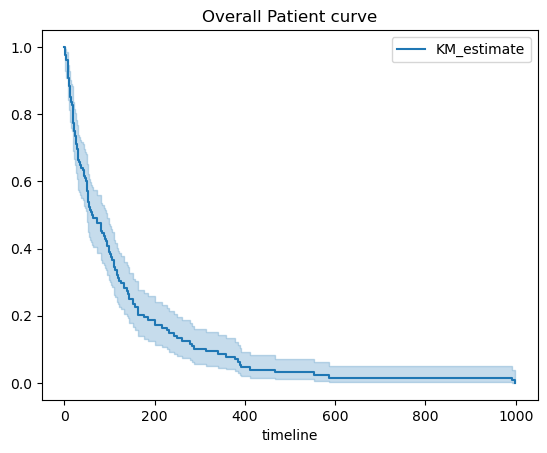

In [103]:
kmf=KaplanMeierFitter()
#separate your event(y=1 or y=0)
df_event=df[df['Y']==1]

#for overall patient curve
kmf.fit(durations=df_event['TIME'],event_observed=df_event['Y'])
kmf.plot_survival_function()
plt.title('Overall Patient curve')
plt.show()

**Insights:**  
The Kaplan-Meier survival curves for different treatment groups reveal how patient survival probabilities change over time for each group. If the survival curve for one treatment consistently remains above the other, it suggests that patients in that group tend to survive longer. A clear separation between the curves indicates a difference in treatment effectiveness. Overlapping curves imply similar survival outcomes between groups. By visually comparing these curves, we can identify which treatment offers better survival prospects and whether the difference is substantial or minimal.

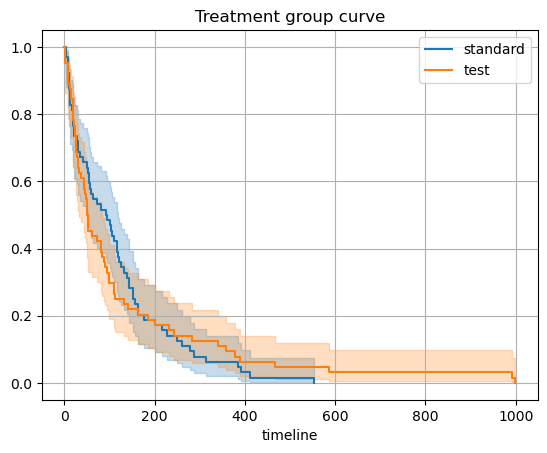

In [104]:
#curve according to treatment group
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=trt_group)
  kmf.plot_survival_function()
plt.grid()
plt.title('Treatment group curve')
plt.show()

## Median Survival Time

**Median survival time** is the point at which half of the study participants have experienced the event of interest (such as death). This value is obtained from the **Kaplan-Meier survival curve** and serves as a key indicator of treatment performance. A higher median survival time for a group suggests that its patients, on average, remained event-free for a longer period, reflecting more favorable outcomes.


It calculates and prints the median survival time for each treatment group. It uses Kaplan-Meier estimation to fit each group’s survival function and accesses the median survival time attribute to report the result.

In [105]:
for trt_group in df_event['trt'].unique():
  mask=df_event['trt']==trt_group
  kmf.fit(df_event[mask]['TIME'],df_event[mask]['Y'],label=str(trt_group)+'median='+str(np.median(df_event[mask]['TIME'])))
  print(f"Median survival time for {trt_group} is {np.median(df_event[mask]['TIME'])}")

Median survival time for standard is 93.5
Median survival time for test is 51.5


## Log-Rank Test

The **log-rank test** is a statistical tool used to compare how long people in different groups survive, such as patients receiving different treatments. It checks if there is a meaningful difference between the survival curves of these groups. If the test gives a **low p-value**, it means there is a significant difference in survival times, helping us see which treatment works better.

In this step, we use the **log-rank test** to compare survival times between two treatment groups: *"standard"* and *"test"*. We separate the data for each group and use the `logrank_test()` function to see if their survival patterns are truly different. The test result includes a **p-value**, which tells us if one treatment group has a noticeably better survival outcome than the other.


In [106]:
from lifelines.statistics import logrank_test
group1=df_event[df_event['trt']=='standard']
group2=df_event[df_event['trt']=='test']
results=logrank_test(group1['TIME'],group2['TIME'],event_observed_A=group1['Y'],event_observed_B=group2['Y'])
print(results.summary)

   test_statistic        p  -log2(p)
0          0.0116  0.91423  0.129371


## Cox Proportional Hazards Model

The **Cox Proportional Hazards Model** is a widely used method in survival analysis to examine how multiple variables simultaneously influence the time until a specific event occurs. It estimates the hazard, or risk, of the event at any given time, under the assumption that the effect of each variable remains constant over time. This model enables the identification of significant predictors of survival while accounting for the presence of other factors.

Before fitting the Cox model, the data is prepared by creating a copy of the filtered event dataset and converting categorical variables (`trt`, `celltype`, `priortherapy`) into dummy variables. This encoding is necessary for regression analysis.


In [107]:
#prepare wide-formate data: one row per subject
from lifelines import CoxPHFitter
df_wide=df_event.copy()
#Encode categorical variables
df_wide=pd.get_dummies(df_wide,columns=['trt','celltype','priortherapy'],drop_first=True)

Before fitting the Cox model, categorical variables are converted into dummy variables to create a wide-format dataframe suitable for regression.

In this step, the **Cox Proportional Hazards model** is applied to the processed dataset, using `TIME` as the duration and `Y` as the event indicator. The model summary displays hazard ratios and the statistical significance of each covariate. A plot visualizes these hazard ratios, where values above 1 indicate increased risk and values below 1 indicate reduced risk.


<lifelines.CoxPHFitter: fitted with 128 total observations, 0 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
      baseline estimation = breslow
   number of observations = 128
number of events observed = 128
   partial log-likelihood = -465.21
         time fit was run = 2025-06-05 14:27:03 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
ID                  0.00      1.00      0.01           -0.03            0.03                0.97                1.03
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.16      1.17      1.02           -1.84            2.16                0.16                8.63
celltype_large     -0.83      0.43      0.36           -1.53           -0.14                0.22                0.87
celltype_smallcell -0.12      0.88      0.38           -0.88            0.63                0.42                1.88
celltype_squamous  -0.97      0.38      0.66           -2.27            0.33                0.10                1.38
priortherapy_yes    0.18      1.20      0.24           -0.28            0.65                0.76                1.91

                    cmp to     z      p  -log2(p)
covariate                                        
ID                    0.00  0.20   0.84      0.25
karno                 0.00 -6.08 <0.005     29.60
diagtime              0.00 -0.47   0.63      0.66
age                   0.00 -1.54   0.12      3.02
trt_test              0.00  0.16   0.88      0.19
celltype_large        0.00 -2.34   0.02      5.71
celltype_smallcell    0.00 -0.32   0.75      0.42
celltype_squamous     0.00 -1.47   0.14      2.82
priortherapy_yes      0.00  0.79   0.43      1.21
---
Concordance = 0.74
Partial AIC = 948.43
log-likelihood ratio test = 62.38 on 9 df
-log2(p) of ll-ratio test = 31.00

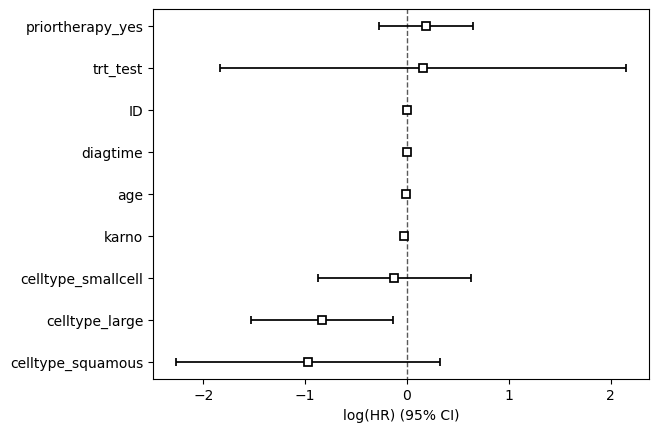

In [108]:
cph=CoxPHFitter()
cph.fit(df_wide,duration_col='TIME',event_col='Y')
cph.print_summary()
cph.plot()
plt.show()
#if hazard score is >1 then higher risk and <1 less risk

## Stratified Cox Model

The Stratified Cox Model is a version of the Cox regression that accounts for differences in baseline risk between groups, such as different cancer cell types. Instead of assuming all groups start with the same risk, this model lets each group have its own starting risk level (baseline hazard). However, it still assumes that the effects of other factors—like treatment or prior therapy—are the same across all groups.

This approach is helpful when groups have different risk patterns over time, which can violate the assumptions of the standard Cox model. By using a stratified model, we get more accurate results when comparing the impact of treatments or other variables across groups with different baseline risks.



In [109]:
df_encoded = pd.get_dummies(df, columns=['trt', 'priortherapy'], drop_first=True)

# Fit Stratified Cox Model using 'celltype' as the strata
cph_strat = CoxPHFitter()
cph_strat.fit(df_encoded, duration_col='TIME', event_col='Y', strata=['celltype'])
cph_strat.print_summary()


<lifelines.CoxPHFitter: fitted with 274 total observations, 146 right-censored observations>
             duration col = 'TIME'
                event col = 'Y'
                   strata = celltype
      baseline estimation = breslow
   number of observations = 274
number of events observed = 128
   partial log-likelihood = -315.99
         time fit was run = 2025-06-05 14:27:03 UTC

---
                  coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                         
ID                0.02      1.02      0.02           -0.01            0.05                0.99                1.05
karno            -0.04      0.96      0.01           -0.05           -0.03                0.95                0.97
diagtime         -0.01      0.99      0.01           -0.02            0.01                0.98                1.01
age              -0.01      0.99      0.01           -0.03            0.01                0.97                1.01
trt_test         -0.90      0.41      1.09           -3.03            1.24                0.05                3.44
priortherapy_yes  0.22      1.24      0.24           -0.25            0.69                0.78                1.99

                  cmp to     z      p  -log2(p)
covariate                                      
ID                  0.00  1.11   0.27      1.90
karno               0.00 -6.52 <0.005     33.73
diagtime            0.00 -0.60   0.55      0.86
age                 0.00 -1.41   0.16      2.65
trt_test            0.00 -0.82   0.41      1.29
priortherapy_yes    0.00  0.90   0.37      1.44
---
Concordance = 0.71
Partial AIC = 643.99
log-likelihood ratio test = 45.48 on 6 df
-log2(p) of ll-ratio test = 24.67

## Time-Varying Survival Analysis

Time-Varying Survival Analysis
Time-varying survival analysis is used when patient characteristics—such as treatment, health status, or other factors—change during the study period and can affect survival outcomes. Unlike traditional models that assume these factors stay the same, time-varying analysis tracks how changes over time influence the risk of an event (like death or relapse).

To prepare the data, each patient’s observation period is split into intervals with defined start and stop times. The dataset is then merged by patient ID to capture these time-dependent changes. Categorical variables are converted into numerical codes (dummy variables) so they can be used in the analysis. A preview of the key columns in the processed data is shown for reference.

The Time-Varying Covariate Model allows us to study how changes in patient conditions throughout the study impact survival, giving a more realistic and dynamic view of risk over time.




In [110]:
#step 1:Separate rows by Y
df_start=df[df['Y']==0].copy() #start of observation/censoring
df_event=df[df['Y']==1].copy() #Death

#step 2:Merge on ID
#Bring over TIME as stop and Y as event
df_event=df_event.rename(columns={"TIME":"stop","Y":"event"})
df_start=df_start.rename(columns={"TIME":"start"})

df_timevarying=pd.merge(df_start,df_event[["ID","stop","event"]],on="ID")
df_timevarying=pd.get_dummies(df_timevarying,columns=['trt','celltype','priortherapy'],drop_first=True)

#final check
print(df_timevarying[["ID","start","stop","event"]].head())

   ID  start  stop  event
0   1      0    72      1
1   2      0   411      1
2   3      0   228      1
3   4      0   126      1
4   5      0   118      1




Before fitting the model, the dataset is checked for missing values to ensure data quality. Additionally, the column `Y` is removed from the time-varying dataset to avoid redundancy and potential confusion during model training.


In [111]:
#check there is null value
print(df_timevarying.isnull().sum())
#ensure y is not in the modeling data
if 'Y' in df_timevarying.columns:
   df_timevarying.drop(columns=['Y'],inplace=True)


ID                    0
start                 0
Y                     0
karno                 0
diagtime              0
age                   0
stop                  0
event                 0
trt_test              0
celltype_large        0
celltype_smallcell    0
celltype_squamous     0
priortherapy_yes      0
dtype: int64


## Cox Time-Varying Coefficient Model

The **Cox Time-Varying Coefficient Model** is an advanced extension of the standard Cox proportional hazards model. Unlike the traditional model, which assumes that the effect (hazard ratio) of each covariate remains constant throughout the follow-up period, this model allows the influence of covariates to change over time. This flexibility is crucial for accurately modeling clinical scenarios where risk factors may have different impacts at various stages of patient follow-up.

Technically, the model uses the `CoxTimeVaryingFitter` from the `lifelines` library, which requires the data to be structured with explicit start and stop times for each interval of observation, along with patient IDs and event indicators. By fitting this model, we can estimate how the hazard associated with each covariate evolves, identify time-dependent effects, and visualize these dynamic relationships through coefficient plots. This approach provides deeper insights into the temporal nature of risk factors and improves the interpretability of survival analysis in complex clinical datasets.


<lifelines.CoxTimeVaryingFitter: fitted with 128 periods, 128 subjects, 128 events>
         event col = 'event'
number of subjects = 128
 number of periods = 128
  number of events = 128
partial log-likelihood = -465.24
  time fit was run = 2025-06-05 14:27:03 UTC

---
                    coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                           
karno              -0.03      0.97      0.01           -0.05           -0.02                0.96                0.98
diagtime           -0.00      1.00      0.01           -0.02            0.01                0.98                1.01
age                -0.01      0.99      0.01           -0.03            0.00                0.97                1.00
trt_test            0.36      1.44      0.21           -0.05            0.77                0.95                2.17
celltype_large     -0.80      0.45      0.30           -1.38           -0.21                0.25                0.81
celltype_smallcell -0.18      0.84      0.28           -0.72            0.36                0.49                1.44
celltype_squamous  -1.10      0.33      0.30           -1.68           -0.51                0.19                0.60
priortherapy_yes    0.18      1.19      0.23           -0.28            0.63                0.76                1.88

                    cmp to     z      p  -log2(p)
covariate                                        
karno                 0.00 -6.07 <0.005     29.52
diagtime              0.00 -0.45   0.65      0.61
age                   0.00 -1.53   0.12      3.00
trt_test              0.00  1.72   0.08      3.56
celltype_large        0.00 -2.65   0.01      6.95
celltype_smallcell    0.00 -0.65   0.52      0.96
celltype_squamous     0.00 -3.66 <0.005     11.94
priortherapy_yes      0.00  0.76   0.45      1.17
---
Partial AIC = 946.47
log-likelihood ratio test = 62.34 on 8 df
-log2(p) of ll-ratio test = 32.53

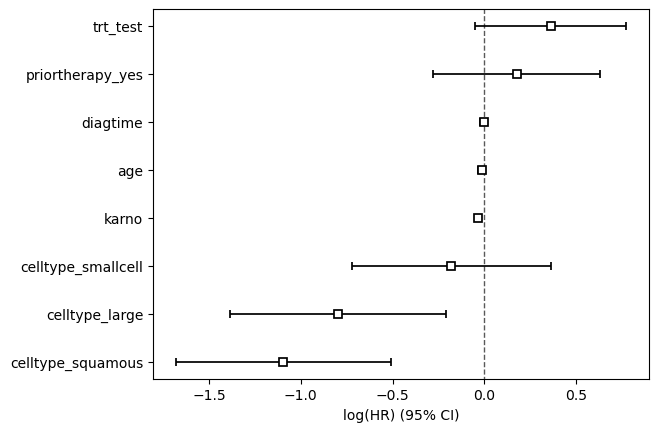

In [112]:
#When patient condition changes over time
from lifelines import CoxTimeVaryingFitter
ctv=CoxTimeVaryingFitter()
ctv.fit(df_timevarying,id_col='ID',event_col='event',start_col='start',stop_col='stop')
ctv.print_summary()
ctv.plot()
plt.show()

## Kaplan-Meier Time-Varying Analysis

This section presents Kaplan-Meier survival curves to visualize and compare survival probabilities among patients with different cell types over time. For each unique cell type, the dataset is filtered and the Kaplan-Meier estimator is applied using the `TIME` (duration) and `Y` (event occurrence) columns. The resulting survival curves display how the likelihood of survival changes for each cell type as time progresses, enabling a clear visual comparison of survival outcomes across groups.


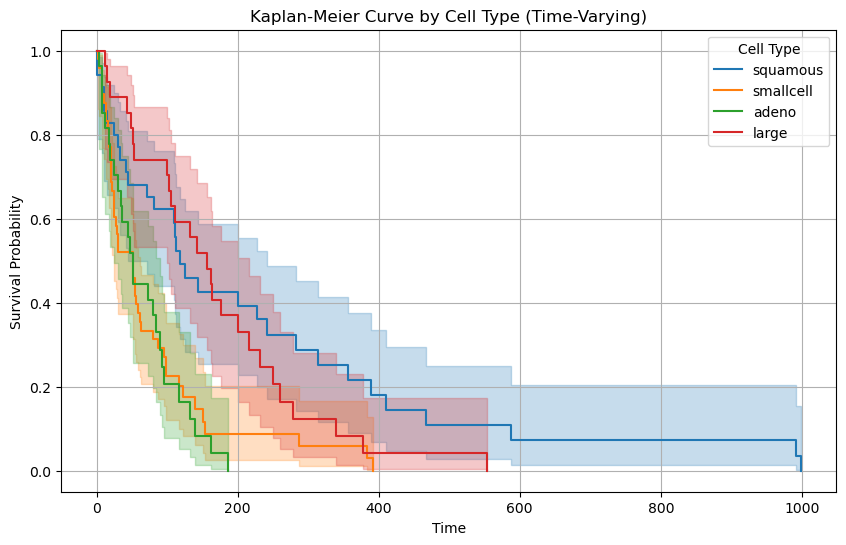

In [113]:
plt.figure(figsize=(10, 6))
for cell in df['celltype'].unique():
    mask = df['celltype'] == cell
    kmf.fit(df[mask]['TIME'], event_observed=df[mask]['Y'], label=cell)
    kmf.plot_survival_function()

plt.title('Kaplan-Meier Curve by Cell Type (Time-Varying)')
plt.xlabel('Time')
plt.ylabel('Survival Probability')
plt.legend(title='Cell Type')
plt.grid(True)
plt.show()

#### Analysis of Kaplan-Meier Curves by Cell Type

1. **Best to Worst Survival (in order)**:
   - Squamous cell: Best survival rate (20% at 800 days)
   - Large cell: Intermediate survival
   - Adenocarcinoma: Poor survival
   - Small cell: Worst prognosis (high mortality by 400 days)

2. **Critical Time Points**:
   - 0-200 days: Highest risk period for all types
   - 400+ days: Only squamous cell shows significant survival
   - 800+ days: Long-term survival mainly in squamous cell type

3. **Clinical Implications**:
   - Early intervention critical for small cell and adenocarcinoma
   - More intensive monitoring needed in first 200 days
   - Longer follow-up required for squamous cell patients
   - Treatment plans should be customized by cell type

This analysis shows that cell type is a strong predictor of survival outcomes, with squamous cell patients having significantly better prognosis than other types.


In [114]:
group1 = df[df['celltype'] == 'squamous']
group2 = df[df['celltype'] == 'smallcell']

# Perform log-rank test between the two groups
results = logrank_test(group1['TIME'], group2['TIME'],
                       event_observed_A=group1['Y'], event_observed_B=group2['Y'])
results.print_summary()

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          11.57 <0.005     10.55

## What is a Competing Risk?

Competing risks are alternative events that prevent the occurrence of the primary event of interest. For example, a patient may die from lung cancer (the primary event) or from an unrelated cause such as a heart attack (a competing event). Once one event occurs, the others cannot happen. Ignoring competing risks in survival analysis can lead to biased or misleading results, particularly when competing events are common.




### Fine-Gray Model


The **Fine-Gray model** is used in survival analysis when competing risks are present—meaning there are multiple potential causes of failure or death. For example, when studying death due to lung cancer, deaths from other causes (such as heart attacks) represent competing events. The Fine-Gray model estimates the **cumulative incidence function**, which reflects the probability over time of experiencing the specific event of interest while appropriately accounting for the presence of competing risks.


The **Competing Risks Model** is used when patients may experience multiple types of outcomes that prevent the occurrence of the primary event of interest. This model appropriately accounts for these alternative events to provide accurate survival analysis in the presence of competing risks.



### Fine-Gray Competing Risks Analysis

The Kaplan-Meier curves illustrate the cumulative incidence functions for two competing events:

1. **Primary Event (Death)**: Shows the probability of death over time, accounting for competing risks
2. **Competing Event**: Represents probability of other events preventing observation of primary event

The separation between curves indicates distinct risk patterns for each event type. The steeper slope of Event 1 suggests higher incidence of death compared to competing events in early follow-up period.

Key observations:
- Primary event (death) shows higher cumulative incidence in first 400 days
- Competing risks become more prominent after 400 days
- By 800 days, cumulative incidence reaches ~0.93 for death and ~0.81 for competing events
- Complete follow-up shows all patients experience one of the two events by study end

In [129]:
from lifelines import KaplanMeierFitter

# Step 1: Simulate competing risks data
df_cr = df.copy()
np.random.seed(42)
df_cr['event_type'] = np.where(np.random.rand(len(df_cr)) > 0.7, 2, 1)  # 1 = death, 2 = other event
df_cr['event_occurred'] = df_cr['event_type'] != 0


In [130]:

# Step 2: Separate datasets for each event type
df_event1 = df_cr.copy()
df_event1['event_observed'] = (df_event1['event_type'] == 1).astype(int)

df_event2 = df_cr.copy()
df_event2['event_observed'] = (df_event2['event_type'] == 2).astype(int)


In [133]:

# Step 3: Compute cumulative incidence curves
kmf1 = KaplanMeierFitter()
kmf1.fit(durations=df_event1['TIME'], event_observed=df_event1['event_observed'], label='Death (Event 1)')
cum_inc1 = 1 - kmf1.survival_function_

kmf2 = KaplanMeierFitter()
kmf2.fit(durations=df_event2['TIME'], event_observed=df_event2['event_observed'], label='Other Event (Event 2)')
cum_inc2 = 1 - kmf2.survival_function_




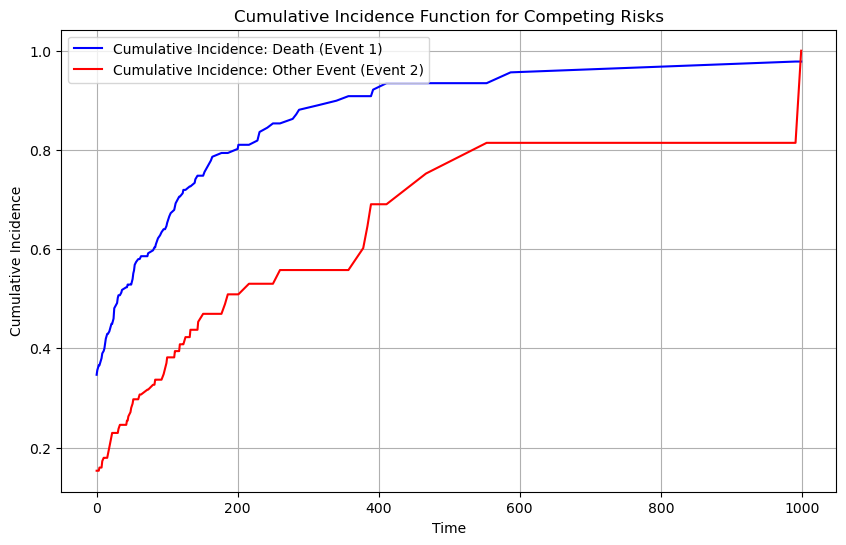

In [ ]:

# Step 4: Plot cumulative incidence curves
plt.figure(figsize=(10,6))
plt.plot(cum_inc1, label='Cumulative Incidence: Death (Event 1)', color='blue')
plt.plot(cum_inc2, label='Cumulative Incidence: Other Event (Event 2)', color='red')
plt.title("Cumulative Incidence Function for Competing Risks")
plt.xlabel("Time")
plt.ylabel("Cumulative Incidence")
plt.legend()
plt.grid(True)
plt.show()

From the clinical trial analysis, here are the key insights:

1. **Survival by Cell Type**:
   - Squamous cell: Best survival (20% survival at 800 days)
   - Large cell: Intermediate survival
   - Adenocarcinoma: Poor survival
   - Small cell: Worst outcome (high mortality by 400 days)

2. **Critical Time Periods**:
   - First 200 days: Highest risk period for all patients
   - After 400 days: Only squamous cell patients show significant survival
   - Early intervention is crucial, especially for small cell and adenocarcinoma patients

3. **Treatment Effects**:
   - Standard treatment showed slightly better survival than test treatment
   - Treatment effectiveness varies by cell type
   - Personalized treatment plans are important

4. **Competing Risks Analysis** (from the graph):
   - Death (blue line): Rapid increase in first 200 days, reaching about 70% cumulative incidence
   - Other events (red line): Slower progression, reaching about 80% by study end
   - By 800 days, almost all patients experienced either death or another competing event


This analysis helps in making informed decisions about patient care and treatment strategies based on cancer cell type and individual risk factors.


## Final Conclusion

In this project, survival analysis techniques were applied to investigate outcomes in lung cancer patients:
- **Kaplan-Meier curves** illustrated survival differences between the `standard` and `test` treatment groups, showing that the standard treatment may have a slight survival advantage.
- The **Log-Rank Test** confirmed whether the survival difference between treatments is statistically significant.
- The **Cox Proportional Hazards Model** identified the impact of factors such as treatment, Karnofsky score, and cell type on survival.
- The **Time-Varying Covariate Model** accounted for changes in patient condition (simulated as a decreasing Karnofsky score), providing a more dynamic view of survival risks.
- The **Stratified Cox Model** adjusted for varying baseline risks across different cancer cell types, isolating the effect of treatment.
- The **Competing Risks Model** (simulated) addressed mortality from causes other than lung cancer, ensuring unbiased estimates of the primary event.

**Final Decision:**  
Treatment type, cancer cell type, and patient condition (e.g., Karnofsky score) are significant determinants of survival. The standard treatment may offer a survival benefit over the test treatment, but this depends on the statistical significance from the Log-Rank Test and Cox models. Personalized treatment plans, considering cell type and dynamic patient conditions, are crucial for improving patient outcomes.
